# Image Filtering and Object Detection

__Objective__: This assessment will test your ability to apply various image processing techniques to identify and isolate objects within an image. You will use image filtering for smoothing and sharpening, convert an image to a binary format, and then use contour detection to place bounding boxes around individual objects.

__Image for the Task__: You will be provided with an image named `screws.jpg`.

## Part 1: Image Loading and Initial Filtering

In this part, you will load the image and apply two different types of filters to understand their effects.

### Sub-task 1.1: Load and Display the Image

* Import the necessary libraries: `cv2`, `numpy`, and `matplotlib.pyplot`.
* Read the image `screws.jpg` into a variable.
* Convert the image from the default BGR color space to grayscale.
* Display the grayscale image.

### Sub-task 1.2: Apply Gaussian Blur

* Apply a Gaussian blur to the grayscale image.
* Experiment with at least two different kernel sizes (e.g., (5, 5) and (15, 15)).
* Display the blurred images and briefly comment on how the change in kernel size affects the image's smoothness and the visibility of noise.

### Sub-task 1.3: Apply a Sharpening Filter

* Create a sharpening kernel using`numpy`.
* Apply this kernel to the original grayscale image using the `cv2.filter2D` function.
* Display the sharpened image.

Image shape: (300, 300, 3)


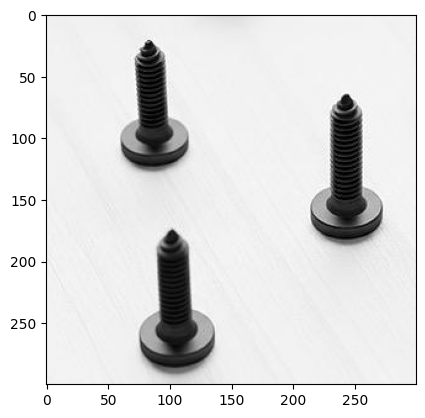

/var/folders/2v/8dp8523d73b_x96ftkvjl6km0000gn/T/ipykernel_17169/1685890368.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


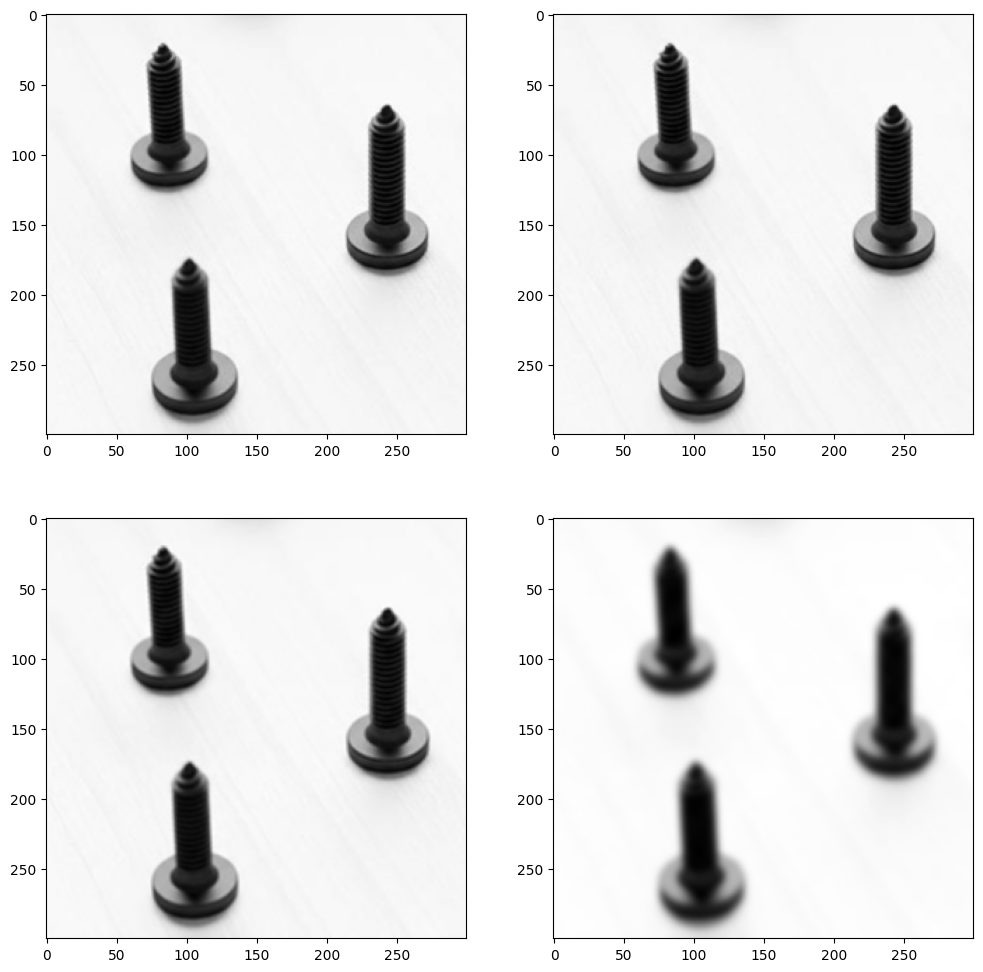

In [ ]:
#Your code goes here
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1.1
image = cv2.imread('screws.jpg')
print(f"Image shape: {image.shape}")
# The shape shows this is not a grey scale image, but has three channels. 
# So I need to convert it to Greyscale
# As it would load as BGR I need to use the BGR to GRAY converter
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.show()

#1.2
#Gaussian Blur calculates the intensity of a pixel based on the intensities of the neighbouring pixels. 
#The weight it gives the neighbouring pixels depends on the distance form the pixel that is being calculated:
#The closer a pixel to the pixel in question, the more weight it has. (The actual pixel itself has the heightest weight.) 
#The rate of gain of weight per distance follows the Gaussian curve. 
#Consequently sigma determines how steep the curve is.
#Gauss curves are infinite, and the area below the curve is 1, 
#However, because the kernel is not infinite, the Gauss curve is truncated.
#Still, all weights in the kernel together must still add up to 1. 
#For that reason all kernel weights are normalised so the sum is 1. 
#E.g. a 3x3 kernel with sigma=0.7 (relatively little effect with high weight of the center): ((0.044, 0.122, 0.044), (0.122, 0.338, 0.122), (0.044, 0.122, 0.044))
# While a high sigma like sigma=2.5 (steeper): ((0.105, 0.114, 0.105), (0.114, 0.123, 0.114), (0.105, 0.114, 0.105)) should blur more. 
# However, if the Kernel is too small, the bluring is cur off too early and the effect is limited.
# For that reaosn there is a practical relationship between sigma and kernel size. The higher the sigma, the bigger the kernel needs to be. 
# So for sigma=2.5 in the images below, the image with the higher kernel ist much more blurred than the version with the smaller kernel.
# On the other hand, for sigma 0.7, the larger kernel doesn't have much effect
image_blur_small_sigma_small_kernel = cv2.GaussianBlur(image_gray, ksize=(3,3), sigmaX=0.7, sigmaY=0.7)
image_blur_small_sigma_large_kernel = cv2.GaussianBlur(image_gray, ksize=(15,15), sigmaX=0.7, sigmaY=0.7)
image_blur_large_sigma_small_kernel = cv2.GaussianBlur(image_gray, ksize=(3,3), sigmaX=2.5, sigmaY=2.5)
image_blur_large_sigma_large_kernel = cv2.GaussianBlur(image_gray, ksize=(15,15), sigmaX=2.5, sigmaY=2.5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
axes[0][0].imshow(image_blur_small_sigma_small_kernel, cmap="gray")
axes[0][1].imshow(image_blur_small_sigma_large_kernel, cmap="gray")
axes[1][0].imshow(image_blur_large_sigma_small_kernel, cmap="gray")
axes[1][1].imshow(image_blur_large_sigma_large_kernel, cmap="gray")
fig.show()



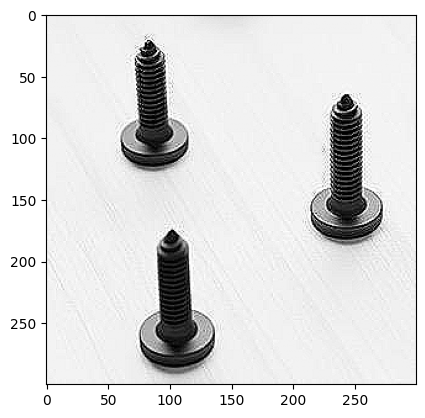

In [ ]:
#1.3 
# A sharpening kernel enhances the differences between a pixel and its neighbours, in particular in the middle ranges.
# So when neighbouring pixels are a little darker, the current pixel's intensity is increased, and vice versa.
# As values <0 and >255 can occur, clipping is applied to keep all values in the valid range.
sharpening_kernel = np.array([[0, -1, 0],
                              [-1, 5,-1],
                              [0, -1, 0]])
# ddpeth=-1 means the output image has the same depth (uint8) as the input image
# That's what forces the clipping to 0-255
# Putting e.g. ddepth=cv2.CV_16S (16 bit signed integer) would avoid clipping, but then the output image would not be displayable directly
# cf. https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html
image_sharpened = cv2.filter2D(image_gray, ddepth=-1, kernel=sharpening_kernel)
plt.imshow(image_sharpened, cmap='gray')
plt.show()

## Part 2: Binary Image Conversion and Object Isolation

Here, you will convert the filtered image into a binary format to clearly separate the objects from the background.

### Sub-task 2.1: Thresholding the Image

* Take the Gaussian blurred image from Sub-task 1.2 (using a (5,5) kernel is a good starting point) and apply thresholding to create a binary image.This will help in creating a clean separation between the screws and the background.
* Display the resulting binary image.

### Sub-task 2.2: Morphological Operations for Noise Reduction

* To clean up the binary image, you may have small white spots in the background or small black holes in the screws.
* Create a 5x5 kernel using `np.ones()`.
* Apply a morphological closing operation (`cv2.MORPH_CLOSE`) to your binary image to fill in any small holes in the objects.
* Display the result of the closing operation.

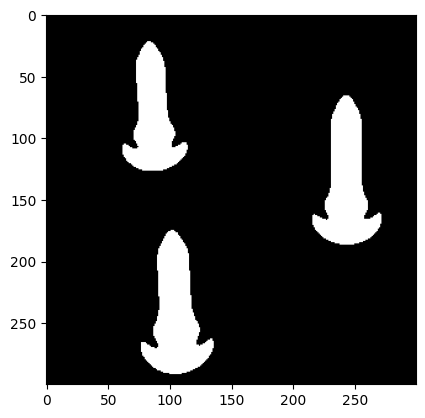

In [ ]:
#2.1
# Otsu's thresholding automatically determines an optimal global threshold value from the image histogram
# cf. https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
# we do not require the threshold value itself, so we use _ to ignore it
# THRESH_BINARY_INV means pixels above the threshold are set to 0 (black), below to 255 (white)
# We need to invert the image so we can later find the contours (which work on white objects).
_, image_binary = cv2.threshold(image_blur_large_sigma_large_kernel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(image_binary, cmap='gray')
plt.show()

# The resulting binary image does not exactly produce and outline of the screws, but for creating boxes it is sufficient.


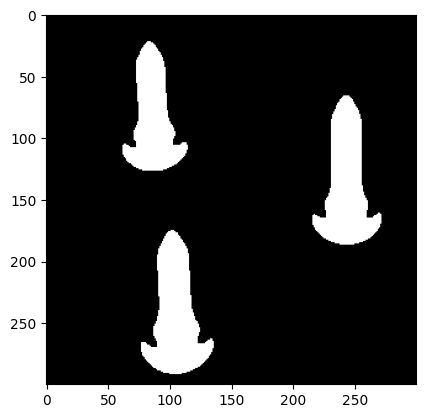

In [ ]:
#2.2
# closing is dilation followed by erosion
# It fills small holes (black spots) in white regions
# Dilation adds pixels to the boundaries of objects in an image
# Sets pixels to white if at least one of the neighbouring pixels that have a 1 in the kernel mask is white (here: any pixel in the neighbouring 5x5 area)
# That means small black pixels in white regions become white
# Erosion removes pixels on object boundaries
# Sets pixels to black if at least one of the neighbouring pixels that have a 1 in the kernel mask is black
# That means small white pixels in black regions become black again
# So small white spots in black regions are removed
closing_kernel = np.ones((5,5), dtype=np.uint8)
image_binary_closed = cv2.morphologyEx(image_binary, cv2.MORPH_CLOSE, closing_kernel)
plt.imshow(image_binary_closed, cmap='gray')
plt.show()

## Part 3: Contour Detection and Bounding Box Generation

In this final part, you will identify each individual object and store its location.

### Sub-task 3.1: Finding Contours

* Use the cleaned binary image from Sub-task 2.2 to find the external contours using the `cv2.findContours` function.

### Sub-task 3.2: Generating a List of Bounding Boxes

* Initialize an empty list called `bounding_boxes`.
* Iterate through each contour found in the previous step.
* For each contour, calculate the bounding rectangle `(x, y, width, height)`.
* Append the coordinates of the top-left corner and the bottom-right corner of the bounding box `(x, y, x+w, y+h)` to your `bounding_boxes` list.
* After the loop, print the `bounding_boxes` list to display the coordinates for each detected screw.

## Sub-task 3.3: Visualizing the Bounding Boxes

* Create a copy of the original color image.
* Loop through your `bounding_boxes` list.
* For each set of coordinates in the list, draw a rectangle on the copied color image.
* Display the final image with the bounding boxes drawn around each screw.

Your final output should look similar to the following example:

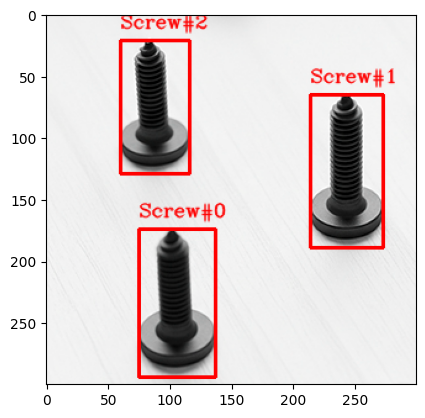

In [13]:
#3.1
# Define local regions for morphological operations
# cv2.RETR_EXTERNAL retrieves only the extreme outer contours, i.e. no nested contours (not relavnt in this image)
# cv2.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points
# e.g. a rectangle would be represented by only 4 points instead of all the points along its 4 edges
# cf. https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html
contours, _ = cv2.findContours(image_binary_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#3.2
bounding_boxes = []
for contour in contours:
    # Get bounding box coordinates for each contour
    x, y, w, h = cv2.boundingRect(contour)
    bounding_boxes.append((x, y, x+w, y+h))
print("Bounding boxes (x1, y1, x2, y2):")
for box in bounding_boxes:
    print(box)


Bounding boxes (x1, y1, x2, y2):
(77, 175, 136, 292)
(216, 66, 272, 187)
(62, 22, 115, 127)


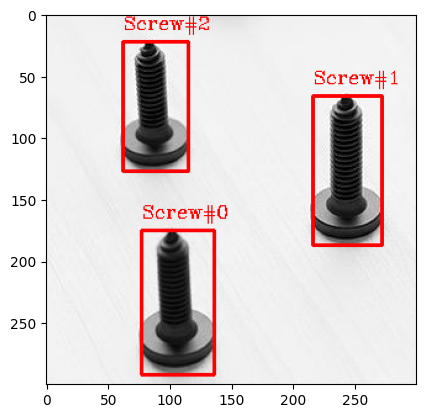

In [34]:
#3.3
# Copy the original image to draw the boxes on
image_with_boxes = image.copy()
# As the image is still in BGR, we need to convert it to RGB so matplotlib displays the colors correctly
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)
# Enumerate boxes to label them
for id, box in enumerate(bounding_boxes):
    x1, y1, x2, y2 = box
    cv2.rectangle(image_with_boxes_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red box with thickness 2
    cv2.putText(image_with_boxes_rgb, f"Screw#{id}", (x1, y1-10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 0), 1)

plt.imshow(image_with_boxes_rgb)
plt.show()